# Create model
 Load data <br>
 Performs hiperparameter search <br>
 Train model with predefined hyperparameters <br>
 Evaluate model with Train/Validation dataset <br>
 Evaluate model with Test dataset
 

## Load libraries 
Install & load python libraries

In [55]:
pip install tabgan==1.3.3 #9500 secs

Note: you may need to restart the kernel to use updated packages.


In [56]:
!pip install lightgbm

In [57]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [58]:
## required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [59]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load data 
Load train & test data from parquet file previously saved <br>
Define limpiar_nombres_columnas & nombres_de_columnas <br>
Define input variables for model <br>
Define is do hyperparameter search or not

In [60]:
hp_search = 0 #whether search hyperparameters or run directly 

s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
df1Train = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Train/Train.parquet")
tg1Train = df1Train['target']

df1Val = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Validation/Validation.parquet")
tg1Val = df1Val['target']


In [61]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
df1Train = limpiar_nombres_columnas(df1Train)
df1Val = limpiar_nombres_columnas(df1Val)

In [62]:
#List of columns from dataframe
def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

nombres_columnas = nombres_de_columnas(df1Train)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


Nombres de columnas: ['id_branch', 'id_receiver', 'date_receiver', 'id_location', 'id_payer', 'id_sender_global', 'net_amount_receiver', 'id_country_receiver_claim', 'id_state_receiver_claim', 'id_state', 'branch_working_days', 'sender_sending_days', 'sender_days_to_last_transaction', 'id_country', 'fraud_classification', 'sender_minutes_since_last_transaction', 'branch_minutes_since_last_transaction', 'sender_days_since_last_transaction', 'branch_trans_3m', 'sender_state', 'branch_has_fraud', 'receiver_has_fraud', 'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 'location_nro_fraud', 'sender_trans_3m', 'range_hist', 'sender_nro_fraud', 'receiver_transaction_count', 'mes', 'hour_receiver', '01_isMexico', '01_sender_branch_state', '01_var_range_hist', '01_receiver_fraud', '01_branch_fraud', '01_location_fraud', '01_sender_fraud', '01_isCashPick', '01_isBankDep', 'sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365', 'sender_days_to_last_transa

#1er prueba
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count','01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [ ]:
#2da prueba
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud',
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    'receiver_transaction_count','01_sender_sending_days',
    'branch_working_days', '01_net_amount_receiver', 
    'sender_minutes_since_last_transaction_2days', 
    'sender_days_to_last_transaction_365', 
    'sender_days_to_last_transaction_7m', '01_hour_receiver']

In [64]:
#Load train & validation and join both for latter split
X_train = df1Train[var_input]
X_test = df1Val[var_input] 
y_train =  pd.DataFrame(df1Train['target']) 
y_test = pd.DataFrame(df1Val['target']) 

X = pd.concat([df1Train[var_input], df1Val[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 


In [65]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

0.003557576657705161

## Hyperparameter search

In [66]:
# Split into train (80%) and validation (20%)
# X_train: features for train, X_test: features for validation
# y_train: labels for train, y_test: labels for validation

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88) 

In [67]:
fit_parameters = {
    #"early_stopping_rounds": 30,           # Number of rounds to stop train when there is no more improvement
    "eval_metric": 'logloss',              # Metric for evaluation
    "eval_set": [(X_test, y_test)],        # Dataset for evaluation during training
    'eval_names': ['valid'],               # Name for validation set
    #'verbose': 100,                        # Log level of output during training
}

In [68]:
# Parameters for hiperparamenter search (RandomizedSearchCV)
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Number of estimatores (trees) to fit

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Maximun number of node leaves

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Maximun tree depth

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [69]:
# Parameters for hiperparamenter search (RandomizedSearchCV) restricted to the first result obtained
param_testeoB = {
    "n_estimators": [460, 480, 400,  500, 510, 520, 530],
    # Number of estimatores (trees) to fit

    "num_leaves": [ 25, 26, 28, 30, 32, 34, 35],
    # Maximun number of node leaves

    "max_depth": [ 17, 18, 19, 20, 21, 22, 23],
    # Maximun tree depth

    "colsample_bytree": [ 0.82 ,0.83, 0.84, 0.86, 0.87],
    # Subsample ratio of columns when constructing each tree

    "min_child_weight": [ 0.0025, 0.0026, 0.0027, 0.0031, 0.0033 ],
    # Minimun weight necessary to create new node 

    "learning_rate": [0.05, 0.06, 0.07, 0.08, 0.09],
    # Learning rate of model

    'subsample': [1],
    # Percentage of rows used per tree building operation

    "objective": ['binary'],
    # Problem to solve. Binary classification in this case

    "importance_type": ["gini", "entropy"],
    # Importante type for characteristics

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # boosting type to evaluate
    
    #"is_unbalance": ['True'],

    "scale_pos_weight" : [0.002, 0.003, 0.004] ,
    
    "force_col_wise" : ['True'],
}


In [70]:
# This parameter defines the number of hiperparameters points to be tested
n_HP_points_to_test = 100


In [71]:
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Trains model using LightGBM with RandomizedSearchCV for hyperparameters

    Parameters:
    - X: Input features of dataset.
    - Y: Labels of dataset.
    - fit_parameters: Parameters for model training and testing.
    - param_testeo: Parameters for random hyperparameter seacrh.
    - n_HP_points_to_test: Number of hiperparameters points to be tested (predetermined: 100).
    - random_state: Random seed for reproducibility (predetermined: 87).

    Returns:
    - Object with RandomizedSearchCV results.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Clean column names calling function limpiar_nombres_columnas
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Create clasifier LightGBM and perform parametric search of hyperparameters
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Train model using train data and parampeters
    result_trainRandom.fit(X_train, y_train.values.ravel(), **fit_parameters)

    return result_trainRandom
   


In [72]:
#If hp_search == 1 it does hyperparameter search 
if hp_search == 1:
    result = entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

In [73]:
if hp_search == 1:
    print(result.best_params_)

{'subsample': 1, 'scale_pos_weight': 0.003, 'objective': 'binary', 'num_leaves': 30, 'n_estimators': 520, 'min_child_weight': 0.0026, 'max_depth': 20, 'learning_rate': 0.07, 'importance_type': 'gini', 'force_col_wise': 'True', 'colsample_bytree': 0.84, 'boosting_type': 'gbdt'}

In [74]:
# Train model with best hyperparameters found in search
if hp_search == 1:
    lgb_classifier = LGBMClassifier(**result.best_params_)

In [75]:
# Set parameters for model from result of previuos hyperparameter search
if hp_search == 0:
    best_params_ = {'subsample': 1,
     'scale_pos_weight': 0.003,
     'objective': 'binary',
     'num_leaves': 30,
     'n_estimators': 520,
     'min_child_weight': 0.0026,
     'max_depth': 20,
     'learning_rate': 0.07,
     'importance_type': 'gini',
     'colsample_bytree': 0.84,
     'boosting_type': 'gbdt'}

    lgb_classifier = LGBMClassifier(**best_params_)

## Train model

In [76]:
# Fit model to data
import lightgbm as lgb
train_data  = lgb.Dataset(X_train, label = y_train)

lgb_classifier.fit(np.array(X_train), y_train)
lbg_predictions_labels = lgb_classifier.predict(X_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 475, number of negative: 13379419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.411009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2675
[LightGBM] [Info] Number of data points in the train set: 13379894, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000036 -> initscore=-10.245913
[LightGBM] [Info] Start training from score -10.245913


# Evaluate model on train/validation data

In [77]:
# Predict using trained model 
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = lgb_classifier.predict_proba(X)

# Extract puntuations (probabilites) for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Create a copy ot the labels for further analysis
Y_c = Y.copy()
Y_c = pd.DataFrame(Y_c)

# Set prediction and puntuationsof model for positive labels
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Y_c dataframe can be used for further analysis
#Y = pd.DataFrame(pd.concat([df1Train['target'], df1Val['target']], ignore_index=True)) 

In [78]:
 Y_c[Y_c['target'] == True]

,target,preds_rf,score_rf
99521,True,True,0.50884959310329258564
136425,True,True,0.99897570213435415987
166402,True,False,0.00055102876331718622
180042,True,True,0.89190676620918218909
187184,True,True,0.99593736065982052530
...,...,...,...
16650420,True,True,0.94951017377237134642
16653629,True,True,0.99985023435273479020
16659081,True,True,0.75743028465834272289
16695469,True,True,0.54110693879361937420


In [79]:
# Model threshold for positive class
Y_c.score_rf[Y_c['preds_rf']==True].min()

0.5009974238073183

In [80]:
# Validate total of each class
Y_c['preds_rf'].value_counts()

preds_rf
False    16724376
True          492
Name: count, dtype: int64

In [81]:
# Confusion matriz for predefined thershold 
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,16724273,0
1,103,492


<Axes: xlabel='score_rf', ylabel='Count'>

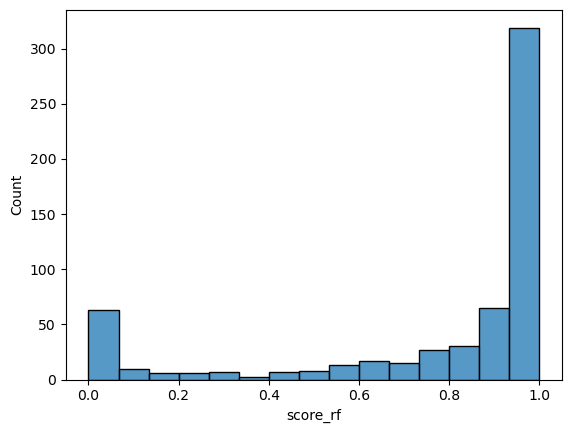

In [82]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [83]:
target_names = ['No fraude', 'Fraude']
print(classification_report(Y_c['target'], Y_c['preds_rf'], target_names=target_names))

              precision    recall  f1-score   support

   No fraude       1.00      1.00      1.00  16724273
      Fraude       1.00      0.83      0.91       595

    accuracy                           1.00  16724868
   macro avg       1.00      0.91      0.95  16724868
weighted avg       1.00      1.00      1.00  16724868



In [84]:
# Divide into tiles and compute cature al 0.04% for train/validation dataset
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')

percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURE .04%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURE .04%:
0.9899159663865547


In [85]:
# Table with totals by n-tile
DECILES_T = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES_T

target,False,True
FRAUD_DECILE,,
1,16143,582
2,16723,2
3,16720,5
4,16725,0
5,16724,1
...,...,...
996,16725,0
997,16725,0
998,16725,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

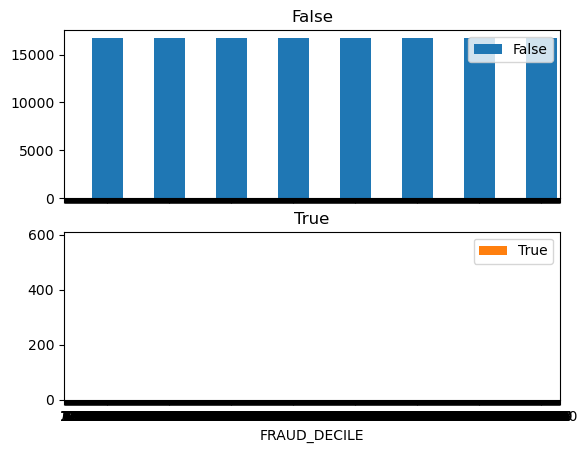

In [86]:
# Plot class by n-tile
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

In [87]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00000099225486394023 0.99999993685413612887
2            0.00000029880861219777 0.00000099223621783965
3            0.00000014437050403993 0.00000029877259494709
4            0.00000008583808458563 0.00000014436700989467
5            0.00000005680286754019 0.00000008583527229762
...                             ...                    ...
996          0.00000000000007350089 0.00000000000008220339
997          0.00000000000006374820 0.00000000000007350016
998          0.00000000000005278933 0.00000000000006374767
999          0.00000000000003893573 0.00000000000005278903
1000         0.00000000000000265582 0.00000000000003893427

[1000 rows x 2 columns]

In [88]:
#Get thresold for .03% of data with highest score
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()

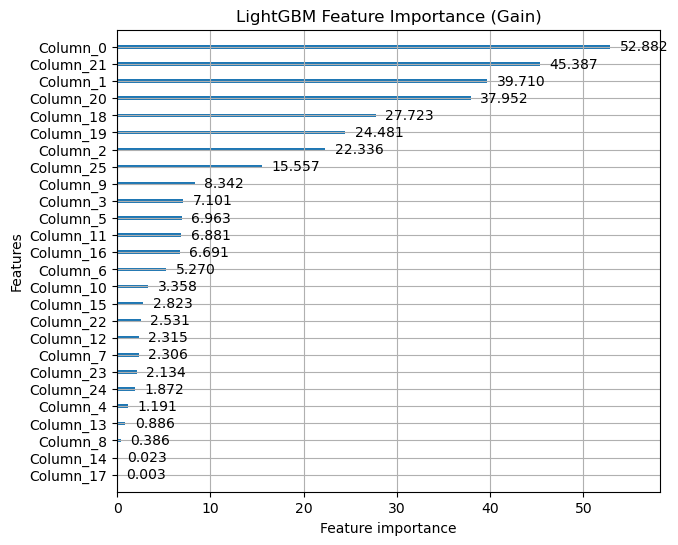

In [89]:
# Plot feature importance using Gain
lgb.plot_importance(lgb_classifier, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

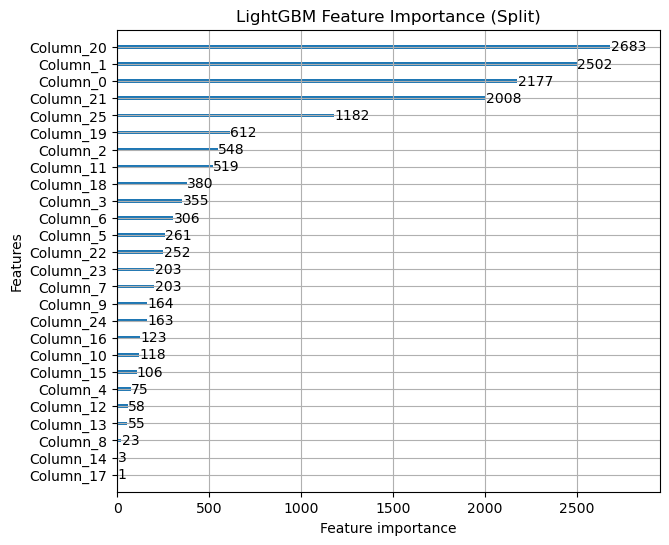

In [90]:
# Plot feature importance using Split
lgb.plot_importance(lgb_classifier, importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

In [91]:
# Run when it has to save new model
import joblib
joblib.dump(lgb_classifier, 'ModeloBite.pkl')
with open("./ModeloBite.txt", "w") as output:
    output.write(str(var_input))


In [92]:
# Save thresholds to recode score
pd.options.display.float_format = "{:,.20f}".format
Buckets = Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}).stack(0, future_stack=True)
Buckets = Buckets.reset_index()
Buckets['final_score'] = 1-(Buckets['FRAUD_DECILE']/1000)
Buckets.to_csv ('./BucketsModeloBite.csv')

In [93]:
# Save feature importance in text file
# Importance is measured in terms of gain according to LightGBM classifier
#np.savetxt('./ModeloFinal_sin_rtcImp.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

## Evaluate model on test data ##

In [94]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model"
tes = pd.read_parquet(f"s3://{s3_url}/TargetTodos/Test/Test.parquet")

In [95]:
## Variable list for input
X = tes[var_input]
Y = tes['target'] 
testeo = tes

In [96]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [97]:
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

Dataset Length:  9754043
Dataset Shape:  (9754043, 77)


In [98]:
testeo['target'].value_counts(dropna=False)

target
False    9753879
True         164
Name: count, dtype: int64

In [99]:
## Variables of model
X_TESTEO = tes[var_input]
X_TESTEO

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,01_isMexico,01_sender_branch_state,01_var_range_hist,01_branch_fraud,01_location_fraud,01_sender_fraud,01_isCashPick,01_isBankDep,sender_days_to_last_transaction_more7m,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_days_to_last_transaction_365,01_sender_days_to_last_transaction_7m,01_hour_receiver
0,22.00000000000000000000,"6,282.00000000000000000000",7,1,0,1,7,21.00000000000000000000,0,False,True,2.76481178795100035472,True,True,False,True,False,0,0.19801980198019802915,1.00000000000000000000,0.32735200402481973159,0.39711191335740070318,0.00000000000000000000,0.01095890410958904118,0.01904761904761904934,0.79166666666666662966
1,86.00000000000000000000,"3,463.00000000000000000000",0,0,0,0,0,4.00000000000000000000,0,False,True,0.87209302325581394832,False,False,False,True,False,0,0.06930693069306931298,0.22678571428571428492,0.13281905081334899332,0.10830324909747292284,0.00000000000000000000,0.02465753424657534179,0.04285714285714285754,0.62500000000000000000
2,20.00000000000000000000,"1,574.00000000000000000000",0,2,0,2,0,17.00000000000000000000,0,False,True,0.78782364490471201712,False,False,False,True,False,0,0.27722772277227725191,0.62142857142857144126,0.08452121415394935056,0.03682310469314079709,0.00000000000000000000,0.01095890410958904118,0.01904761904761904934,0.75000000000000000000
3,25.00000000000000000000,"3,300.00000000000000000000",0,3,0,2,0,5.00000000000000000000,0,True,True,0.62111801242236019949,False,False,False,True,False,0,0.10891089108910891048,0.03571428571428571230,0.14103639107831628108,0.07220216606498194856,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.87500000000000000000
4,10.00000000000000000000,"6,737.00000000000000000000",2,6,0,5,2,21.00000000000000000000,0,True,True,0.81417880762350502977,True,True,False,True,False,0,1.00000000000000000000,1.00000000000000000000,0.46050645648163673895,0.05054151624548736121,0.00000000000000000000,0.00821917808219178002,0.01428571428571428527,0.95833333333333337034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9754038,12.00000000000000000000,"2,451.00000000000000000000",0,1,0,0,0,2.00000000000000000000,0,True,True,0.32772916461835938096,False,False,False,True,False,0,0.08910891089108910479,0.68928571428571427937,0.32399798759013920257,0.03610108303249097428,0.00000000000000000000,0.15616438356164383250,0.27142857142857140795,0.62500000000000000000
9754039,1.00000000000000000000,"2,334.00000000000000000000",0,5,1,4,0,12.00000000000000000000,0,True,True,0.27459951719912883972,False,False,False,False,True,0,0.07920792079207920888,0.29999999999999998890,0.17709206775113198185,0.03610108303249097428,0.00034722222222222224,0.00000000000000000000,0.00000000000000000000,0.41666666666666668517
9754040,2.00000000000000000000,"5,762.00000000000000000000",0,10,3,7,0,17.00000000000000000000,0,False,True,2.06662377067813807230,False,False,False,False,True,0,0.18811881188118811936,0.51249999999999995559,0.06490021801106825305,0.32129963898916968912,0.00000000000000000000,0.01917808219178082293,0.03333333333333333287,0.75000000000000000000
9754041,36.00000000000000000000,29.00000000000000000000,0,2,0,2,0,4.00000000000000000000,0,False,True,0.44301352221506762330,False,False,False,False,True,0,0.02970297029702970160,0.07321428571428571785,0.02314271339929565782,0.06209386281588447770,0.00000000000000000000,0.03561643835616438297,0.06190476190476190688,0.50000000000000000000


In [100]:
# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = pd.DataFrame(testeo['target'])

# Predict test using trained model
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Extract puntuations (probabilites) for positive class
# Assumes that second column has probabilites for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [101]:
# Create a copy DataFrame 'Y_TESTEO' to preserve original data
Y_TESTEO_c = Y_TESTEO.copy()

# Set prediction and puntuationsof model for positive labels
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf
Y_TESTEO_c['score_rf'] = score_rf

# Get classification
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte

In [102]:
# Confusion matriz for predefined thershold 
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['preds_rf']))

,0,1
0,9753877,2
1,150,14


In [103]:
# Confusion matriz for selected thershold 
Y_TESTEO_c['pred_corte'] = Y_TESTEO_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_TESTEO_c['target'], Y_TESTEO_c['pred_corte']))

,0,1
0,9724362,29517
1,45,119


In [104]:
# Divide into tiles and compute cature al 0.04% for train/validation dataset
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}

percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['FRAUD_DECILE'] = np.nan
Y_TESTEO_c['FRAUD_DECILE'] = percentiles
Y_TESTEO_c['FRAUD_DECILE'] = Y_TESTEO_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURE .04%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURE .04%:
0.7195121951219512


In [105]:
DECILES = pd.crosstab(Y_TESTEO_c['FRAUD_DECILE'], Y_TESTEO_c['target'])

In [106]:
DECILES

target,False,True
FRAUD_DECILE,,
1,9657,98
2,9739,15
3,9749,5
4,9748,6
5,9746,8
...,...,...
996,9754,0
997,9754,0
998,9754,0


In [107]:
Y_TESTEO_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': ['min', 'max']}) 

score_rf                       
                                min                    max
FRAUD_DECILE                                              
1            0.00000103064645090860 0.99998186127055199712
2            0.00000030709741324569 0.00000103055844204780
3            0.00000014751749447303 0.00000030707195457855
4            0.00000008725442521782 0.00000014751242106705
5            0.00000005727304380981 0.00000008725086475443
...                             ...                    ...
996          0.00000000000006984531 0.00000000000007791355
997          0.00000000000006095902 0.00000000000006984363
998          0.00000000000005076709 0.00000000000006095590
999          0.00000000000003804645 0.00000000000005076621
1000         0.00000000000000262998 0.00000000000003804425

[1000 rows x 2 columns]

array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

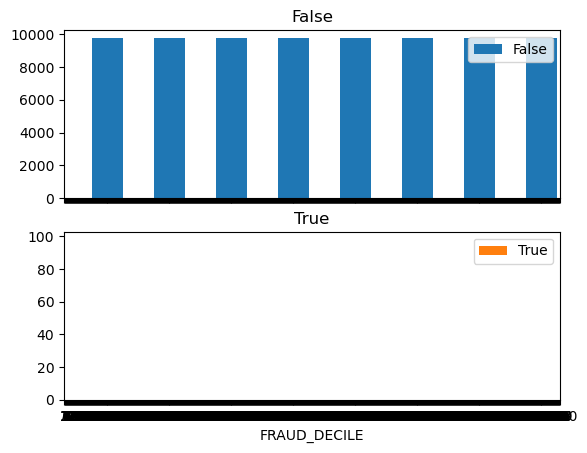

In [108]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)